# Predict energy demand in Australia

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [30]:
region = "NEM"

### Demand

In [183]:
# demand = pd.read_csv(
#     "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020.csv",
#     index_col=0,
#     parse_dates=True
# )

In [185]:
# demand = demand.sum(axis=1)

In [186]:
# demand.plot()

In [187]:
# dem_da = xr.DataArray(
#     demand.squeeze(),
#     dims=["time"],
#     coords={"time": demand.index.values}
# )

In [188]:
# dem_da = dem_da.expand_dims({"region": [region]})

In [189]:
# dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

In [198]:
dem_da = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc"
)["demand_stl"]

In [199]:
dem_da = dem_da.sel(region=region).expand_dims({"region": [region]})

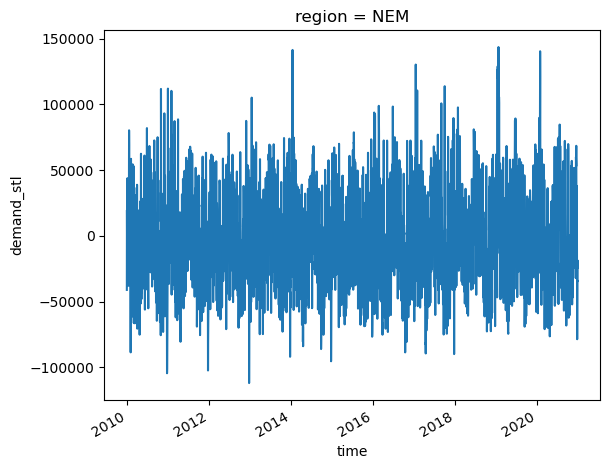

In [200]:
dem_da.plot()

### Predictors

In [201]:
files = fn.get_predictor_files(region, "pop_dens_log_mask")

In [202]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [203]:
pred_ds.data_vars

Data variables:
    hdd       (region, time) float64 0.6528 0.5974 0.6455 ... 4.369 2.011 0.4213
    cdd3      (region, time) float64 nan nan 1.184 ... 0.0002397 0.0002397
    cdd       (region, time) float64 1.29 0.9346 1.329 ... 0.0002397 0.0002397
    mtpr      (region, time) float64 3.262e-05 9.198e-05 ... 2.375e-05 9.379e-06
    t2m4      (region, time) float64 nan nan nan 295.5 ... 289.9 289.4 288.4
    t2m       (region, time) float64 295.3 294.8 295.3 ... 286.8 289.2 291.2
    q         (region, time) float64 10.62 10.66 10.15 ... 6.646 9.317 10.09
    t2m3      (region, time) float64 nan nan 295.2 295.6 ... 289.5 287.4 289.1
    t2max     (region, time) float64 nan 300.5 300.5 302.4 ... 290.5 292.3 295.5
    rh        (region, time) float64 61.73 64.05 61.65 ... 67.2 79.87 75.64
    hdd3      (region, time) float64 nan nan 0.632 0.5421 ... 3.065 3.734 2.267
    hdd4      (region, time) float64 nan nan nan 0.5698 ... 2.427 2.801 2.906
    msdwswrf  (region, time) float64 304.5 

## Prepare data

In [207]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
time_cols = ["is_weekend"]
# time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [208]:
# region_dfs[region]["year"] = region_dfs[region].index.year

In [209]:
region_dfs[region]

,demand,is_weekend,hdd,cdd3,cdd,mtpr,t2m4,t2m,q,t2m3,t2max,rh,hdd3,hdd4,msdwswrf,w10,cdd4,t2min
2010-01-01,-41100.149287,0,0.118780,1.453974,0.679239,0.000091,297.341933,295.870988,13.489145,297.295903,300.485824,75.128747,0.036643,0.040722,197.973909,2.830567,1.527149,292.012007
2010-01-02,19560.909302,1,0.645959,0.896084,0.806275,0.000046,296.655628,294.734547,11.808675,296.021925,299.249538,67.511117,0.248898,0.188951,242.577153,3.126008,1.292058,289.973992
2010-01-03,-6000.400994,1,0.737633,0.768520,0.819948,0.000043,295.639543,294.492139,10.877124,295.032704,299.216460,64.008907,0.500748,0.371060,288.584846,2.530935,0.877059,289.878526
2010-01-04,-24359.584905,0,0.163599,0.842474,0.901100,0.000025,295.252685,295.912372,10.928427,295.046498,300.625332,61.105331,0.515688,0.416439,282.626199,2.439562,0.801675,290.675302
2010-01-05,-29769.122085,0,0.176157,0.963023,1.167922,0.000019,295.463351,296.713654,11.325861,295.706201,302.088325,60.408064,0.359087,0.430783,290.435774,2.519583,0.923845,291.123327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,-57828.840996,1,0.179108,0.844597,1.474200,0.000035,294.649297,296.801253,9.327779,294.875035,301.588843,51.963492,0.670255,0.698567,302.607625,2.521765,0.839774,291.434384
2020-12-27,-34042.669869,1,0.697849,1.153365,1.477572,0.000023,295.152100,295.982893,9.544473,295.633280,303.610182,53.313259,0.569424,0.677120,282.960880,3.300125,1.002856,289.833397
2020-12-28,-34600.457336,0,1.354944,1.251417,0.802324,0.000058,295.142041,293.667919,9.509420,295.484252,299.671006,58.234790,0.743900,0.765770,290.272281,2.885665,1.065620,288.993607
2020-12-29,-18781.824579,0,0.631731,0.858395,0.295133,0.000093,295.091930,293.914562,10.612652,294.522021,298.646897,66.307408,0.894774,0.715824,252.132550,2.584540,1.012361,289.808097


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [210]:
# def sel_train_test(df, first_train_year, last_test_year):
#     """
#     Selects df for training and test years. Might be used to e.g.
#     exclude a validation set.
#     """
#     return df[(df.index.year >= first_train_year) & (df.index.year <= last_test_year)]

In [211]:
first_train_year = 2010
last_train_year = 2016

In [212]:
first_test_year = 2017
last_test_year = 2019

In [213]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [214]:
train_X, test_X, train_y, test_y = fn.split(
    sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [215]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(2557, 17) (1095, 17) (2557,) (1095,)


## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [216]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [217]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [218]:
logo = fn.leave_one_group_out(
    train_X,
    train_y,
    dem_da.sel(time=slice(str(first_train_year), str(last_train_year))),
    str(first_train_year),
    str(last_train_year)
)

[2010 2010 2010 ... 2016 2016 2016]


In [219]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 8min 15s, sys: 6.94 s, total: 8min 22s
Wall time: 8min 22s


In [220]:
model.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([-25596.70702014, -25220.01043454, -24050.47998661, -24074.5988493 ,
         -24904.1375501 , -24135.85089145, -26521.96642315]),
  'avg_score': -24929.10730789867,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 16),
  'cv_scores': array([-30331.08877104, -27547.964736  , -27633.70511261, -26706.69953206,
         -28720.6336997 , -28978.31338288, -29889.9866039 ]),
  'avg_score': -28544.055976881875,
  'feature_names': ('0', '16')},
 3: {'feature_idx': (0, 13, 16),
  'cv_scores': array([-26478.20129678, -24781.45324007, -22433.69509255, -23481.98769608,
         -24615.85592779, -23985.37213377, -25503.71222352]),
  'avg_score': -24468.61108722221,
  'feature_names': ('0', '13', '16')},
 4: {'feature_idx': (0, 7, 13, 16),
  'cv_scores': array([-25126.76378094, -23725.76922888, -21465.41836872, -23095.64548495,
         -22846.19131319, -22678.17764792, -24520.56850428]),
  'avg_score': -23351.219189838335,
  'feature_names': ('0', '

In [221]:
model.k_feature_idx_

(0, 3, 4, 7, 11, 13, 16)

In [222]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['is_weekend', 'cdd', 'mtpr', 'q', 'hdd3', 'msdwswrf', 't2min']


In [223]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-25596.70702013783, -25220.010434542033, -240...",-24929.107308,"(0,)",831.995469,861.855479,351.851026
2,"(0, 16)","[-30331.088771036604, -27547.96473600152, -276...",-28544.055977,"(0, 16)",1177.889314,1220.163327,498.129592
3,"(0, 13, 16)","[-26478.201296775616, -24781.45324007419, -224...",-24468.611087,"(0, 13, 16)",1186.654336,1229.242922,501.836322
4,"(0, 7, 13, 16)","[-25126.76378093626, -23725.769228881538, -214...",-23351.21919,"(0, 7, 13, 16)",1093.98939,1133.252265,462.6483
5,"(0, 4, 7, 13, 16)","[-25373.99758877304, -22942.864922989822, -207...",-22929.381643,"(0, 4, 7, 13, 16)",1257.165139,1302.284332,531.655352
6,"(0, 4, 7, 11, 13, 16)","[-25293.56902069236, -23320.447860448035, -195...",-22634.966376,"(0, 4, 7, 11, 13, 16)",1558.729859,1614.672099,659.187124
7,"(0, 3, 4, 7, 11, 13, 16)","[-25006.30263861, -22869.20698101181, -19248.3...",-22620.260657,"(0, 3, 4, 7, 11, 13, 16)",1572.36465,1628.796237,664.953279
8,"(0, 3, 4, 7, 11, 12, 13, 16)","[-25054.244967358343, -22879.670205020695, -19...",-22698.792085,"(0, 3, 4, 7, 11, 12, 13, 16)",1393.224467,1443.226779,589.194865
9,"(0, 3, 4, 7, 11, 12, 13, 15, 16)","[-25058.564326218286, -22932.784319445756, -20...",-22733.078832,"(0, 3, 4, 7, 11, 12, 13, 15, 16)",1449.262986,1501.2765,612.893565
10,"(0, 1, 3, 4, 7, 11, 12, 13, 15, 16)","[-25075.048890955368, -22925.53284900914, -201...",-22752.724538,"(0, 1, 3, 4, 7, 11, 12, 13, 15, 16)",1394.061003,1444.093338,589.548637


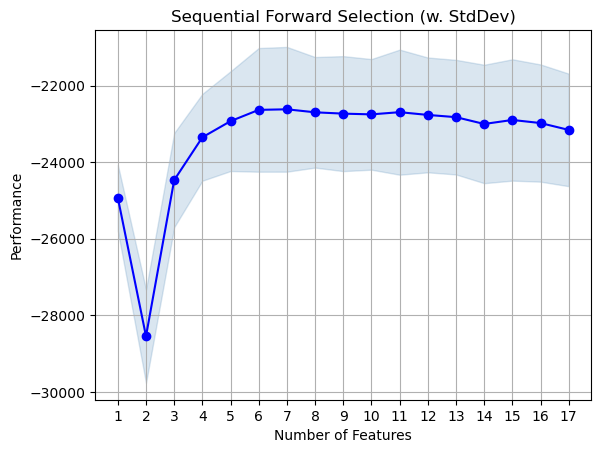

In [224]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [225]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 100) # size of tree, how many end nodes
}

In [226]:
retain = ["demand"] + selected_features

In [227]:
final_features = region_dfs[region][retain]

In [228]:
final_features.head()

,demand,is_weekend,cdd,mtpr,q,hdd3,msdwswrf,t2min
2010-01-01,-41100.149287,0,0.679239,0.000091,13.489145,0.036643,197.973909,292.012007
2010-01-02,19560.909302,1,0.806275,0.000046,11.808675,0.248898,242.577153,289.973992
2010-01-03,-6000.400994,1,0.819948,0.000043,10.877124,0.500748,288.584846,289.878526
2010-01-04,-24359.584905,0,0.901100,0.000025,10.928427,0.515688,282.626199,290.675302
2010-01-05,-29769.122085,0,1.167922,0.000019,11.325861,0.359087,290.435774,291.123327


In [229]:
train_X, test_X, train_y, test_y = fn.split(
    sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [230]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [231]:
rf = ExtraTreesRegressor()

In [232]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2010 2010 2010 ... 2016 2016 2016]


In [233]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 11min 52s, sys: 20.7 s, total: 12min 13s
Wall time: 13min 57s


In [234]:
best_params

{'max_depth': 8,
 'max_leaf_nodes': 87,
 'min_samples_leaf': 12,
 'n_estimators': 209}

## Finalise model

In [235]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [236]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [237]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [238]:
pred_train.shape

(2557,)

In [239]:
pred_test.shape

(1095,)

## Evaluate performance

In [240]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [241]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [242]:
train_scores

[0.3587817393153685,
 20538.27585572539,
 730381470.2186668,
 1.947356024510503,
 15948.084418072876]

In [243]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [244]:
test_scores

[0.32894408062793445,
 22809.978051033635,
 890421977.51502,
 1.6191515208946945,
 17832.44418929724]

In [245]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

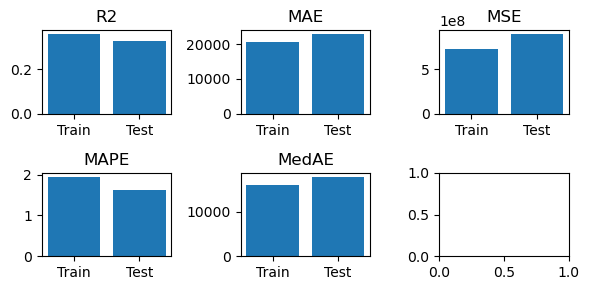

In [246]:
plot_scores(train_scores, test_scores, metric_names)

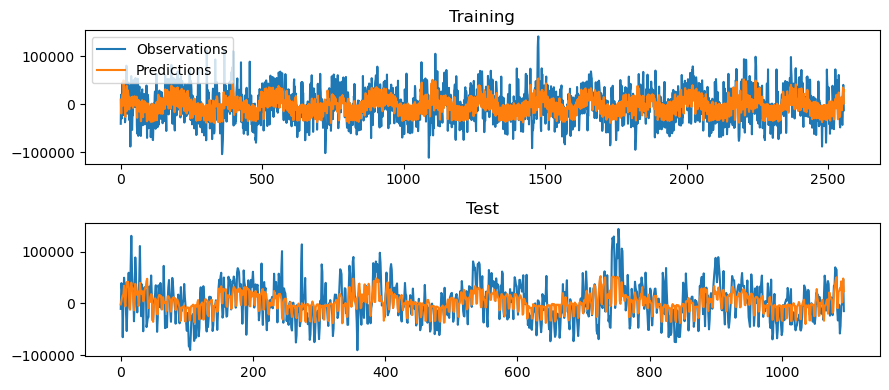

In [247]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

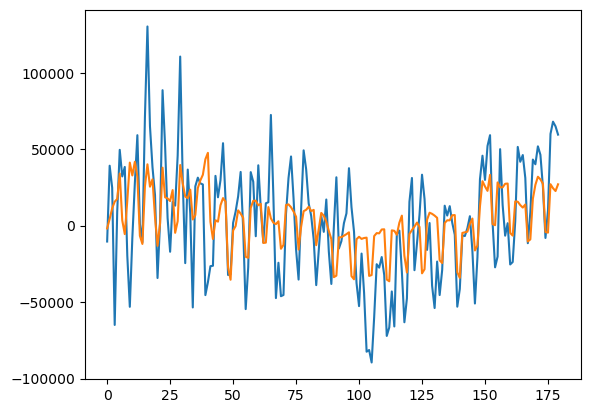

In [248]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [112]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=2,
)

In [113]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=2,
)

In [114]:
perm_train

{'importances_mean': array([0.177155  , 0.05666925, 0.00144561, 0.00985985, 0.53398609,
        0.17049582, 0.00094452]),
 'importances_std': array([5.15550787e-04, 1.07742284e-04, 6.34458874e-06, 4.93632263e-04,
        5.60215008e-04, 5.46410985e-06, 2.52766840e-05]),
 'importances': array([[0.17663945, 0.17767055],
        [0.056777  , 0.05656151],
        [0.00143926, 0.00145195],
        [0.00936622, 0.01035349],
        [0.5345463 , 0.53342587],
        [0.17049036, 0.17050129],
        [0.00091924, 0.0009698 ]])}

In [115]:
perm_test

{'importances_mean': array([1.53757324e-01, 5.89022394e-02, 7.14255622e-04, 6.54215064e-03,
        5.38360922e-01, 1.65642262e-01, 3.56746693e-04]),
 'importances_std': array([4.52798394e-03, 1.14930909e-03, 8.76817433e-06, 1.05591314e-04,
        1.40634946e-02, 4.37519790e-03, 4.01823902e-06]),
 'importances': array([[1.49229340e-01, 1.58285308e-01],
        [5.77529303e-02, 6.00515485e-02],
        [7.23023796e-04, 7.05487448e-04],
        [6.64774196e-03, 6.43655933e-03],
        [5.52424416e-01, 5.24297427e-01],
        [1.70017460e-01, 1.61267064e-01],
        [3.60764932e-04, 3.52728454e-04]])}

In [116]:
fn.print_perm_imp(perm_train, selected_features)

hdd      0.534 +/- 0.001
is_weekend 0.177 +/- 0.001
t2min    0.170 +/- 0.000
msdwswrf 0.057 +/- 0.000
cdd      0.010 +/- 0.000
w10      0.001 +/- 0.000
mtpr     0.001 +/- 0.000


In [117]:
fn.print_perm_imp(perm_test, selected_features)

hdd      0.538 +/- 0.014
t2min    0.166 +/- 0.004
is_weekend 0.154 +/- 0.005
msdwswrf 0.059 +/- 0.001
cdd      0.007 +/- 0.000
w10      0.001 +/- 0.000
mtpr     0.000 +/- 0.000
